In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
import pandas as pd
from tensorflow import keras
from sklearn.manifold import TSNE
import os
from collections import Counter

#### read fasta stuff

In [2]:
def read_fasta(input_f):
    sequences = []
    current_seq = ""
    with open(input_f, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if current_seq:
                    sequences.append(current_seq)
                    current_seq = ""
            else:
                current_seq += line
        if current_seq:
            sequences.append(current_seq)
    return sequences

def select_random_sequences(sequences, num_samples=10000):
    if len(sequences) < num_samples :
        raise ValueError("The number of requested sequences exceeds the initial list size.")

    return random.sample(sequences, num_samples)


def encode_sequences_one_hot_with_gap(sequences, max_length=None) :

    amino_acids = '-ACDEFGHIKLMNPQRSTVWY'
    aa_to_idx = {aa: idx for idx, aa in enumerate(amino_acids)}
    valid_sequences = [seq for seq in sequences if all(aa in aa_to_idx for aa in seq)]

    if not valid_sequences :  # Return empty array if no valid sequences remain
        return np.array([])

    # Set maximum length
    if max_length is None :
        max_length = max(len(seq) for seq in valid_sequences)

    # Initialize the output matrix with zeros
    M = len(valid_sequences)
    L = max_length
    encoded_matrix = np.zeros((M, L, len(amino_acids)), dtype=np.float32)

    # Encode each sequence
    for i, seq in enumerate(valid_sequences) :
        for j, aa in enumerate(seq[:max_length]) :  # Truncate sequences longer than max_length
            encoded_matrix[i, j, aa_to_idx[aa]] = 1.0  # One-hot encode valid amino acids and gaps
    return encoded_matrix

#### vae model

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a sequence."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Encoder(layers.Layer):
    """Encodes sequences into latent space."""
    
    def __init__(self, latent_dim, intermediate_dims=[256, 128, 64], **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.dense_layers = []
        for dim in intermediate_dims:
            self.dense_layers.append(layers.Dense(dim, activation='relu'))
            self.dense_layers.append(layers.BatchNormalization())
            self.dense_layers.append(layers.Dropout(0.3))
        
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
    
    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        
        return z_mean, z_log_var, z

class Decoder(layers.Layer):
    """Decodes a latent space point into a sequence."""
    
    def __init__(self, original_dim, intermediate_dims=[64, 128, 256], **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.dense_layers = []
        for dim in intermediate_dims:
            self.dense_layers.append(layers.Dense(dim, activation='relu'))
            self.dense_layers.append(layers.BatchNormalization())
            self.dense_layers.append(layers.Dropout(0.3))
        
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')
    
    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        
        return self.dense_output(x)

class VAE(Model):
    """Variational Autoencoder for protein sequences."""
    
    def __init__(self, original_dim, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)
        
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        # Add KL divergence regularization loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        
        # Scale KL loss by input dimension to balance it with reconstruction loss
        kl_loss = kl_loss * (1.0 / self.original_dim)
        
        self.add_loss(kl_loss)
        return reconstructed
    
    def encode(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return z_mean, z_log_var, z
    
    def decode(self, z):
        return self.decoder(z)
    
    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'original_dim': self.original_dim,
            'latent_dim': self.latent_dim
        })
        return config
    

# Rebuild the model architecture
vae = VAE(original_dim=5523, latent_dim=32)

dummy_input = np.zeros((1, 5523), dtype=np.float32)  # Match input shape
_ = vae(dummy_input)  # Force layer creation

vae.load_weights('models/200000seq_best_vae_model.h5')  # Load weights

vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │     1,461,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │     1,464,659 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,925,907 (11.16 MB)

 Trainable params: 2,924,115 (11.15 MB)

 Non-trainable params: 1,792 (7.00 KB)

##### wrap the 3D→32 encoder:
Turning trained VAE into an standalone encoder for a deterministic feature extractor.
this model mapes high dim flattened matrix to latent 32 dim space.
that is the whole point

In [4]:
# build a standalone encoder that outputs only z_mean
# 1) One‑hot 3D input
inp_3d = layers.Input(shape=(263, 21), name='onehot_input')

# 2) Flatten to the original_dim your VAE expects
flat   = layers.Flatten(name='flatten')(inp_3d)

# 3) Call encode() without the training kwarg
z_mean, z_logvar, z = vae.encode(flat)

# 4) Build the encoder model
encoder = Model(inputs=inp_3d, outputs=z_mean, name='encoder_3d_to_32')
encoder.summary()

Model: "encoder_3d_to_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ onehot_input (InputLayer)       │ (None, 263, 21)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5523)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Encoder)               │ [(None, 32), (None,    │     1,461,248 │
│                                 │ 32), (None, 32)]       │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,461,248 (5.57 MB)

 Trainable params: 1,460,352 (5.57 MB)

 Non-trainable params: 896 (3.50 KB)

##### preparing data: getting labled sequence, split them for training/val/test (without flattening them cuz encoder would do it)

In [8]:
# 1) Path to your labeled-folder
data_dir = "hmm_20"

# 2) Find all .fasta files in there
fasta_files = [f for f in os.listdir(data_dir) if f.lower().endswith('.fasta')]

# 3) Read & count
label_counts = {}
all_seqs     = []
all_labels   = []

suffix = "_noInserts_noGaps_noDuplicates"

for fname in fasta_files:
    # strip extension
    base = os.path.splitext(fname)[0]
    # remove the unwanted suffix if present
    if base.endswith(suffix):
        label = base[:-len(suffix)]
    else:
        label = base

    path  = os.path.join(data_dir, fname)
    seqs  = read_fasta(path)                # your existing FASTA reader
    n     = len(seqs)

    label_counts[label] = n
    all_seqs.extend(seqs)
    all_labels.extend([label] * n)

# 4) Print summary
print(f"Found {len(label_counts)} classes, {sum(label_counts.values())} total sequences\n")
for lbl, cnt in label_counts.items():
    print(f"  {lbl:30s} : {cnt}")

# 5) Map labels → integer IDs
unique_labels = sorted(label_counts.keys())
label_to_idx  = {lbl:i for i,lbl in enumerate(unique_labels)}
y_labels      = np.array([label_to_idx[lbl] for lbl in all_labels], dtype=np.int32)

print("\nLabel → index mapping:")
for lbl, idx in label_to_idx.items():
    print(f"  {lbl:30s} → {idx}")

print(f"\nall_seqs  length: {len(all_seqs)}")
print(f"y_labels  shape : {y_labels.shape}")

# 0) your amino‑acid map (same as in your encoder)
amino_acids = '-ACDEFGHIKLMNPQRSTVWY'
aa_to_idx   = {aa: i for i, aa in enumerate(amino_acids)}

# 1) Build a mask of “valid” sequences (only drop those that truly have bad chars)
valid_idxs = [
    i for i, seq in enumerate(all_seqs)
    if all(aa in aa_to_idx for aa in seq)
]

# 2) Filter both sequences *and* labels
filtered_seqs   = [all_seqs[i]    for i in valid_idxs]
filtered_labels = [y_labels[i]     for i in valid_idxs]

# 3) Now one‑hot encode the filtered list
X_lab_onehot = encode_sequences_one_hot_with_gap(filtered_seqs, max_length=263)
y_lab = np.array(filtered_labels, dtype=np.int32)

print("After filtering:", X_lab_onehot.shape, y_lab.shape)


Found 15 classes, 1758 total sequences

  aurora_kinases                 : 32
  calcium_calmodulin_dependent_kinases : 32
  calcium_dependent_kinases      : 80
  cAMP_dependent_protein_kinases : 27
  casein_kinases                 : 31
  CBL_interacting_protein_kinases : 31
  cyclin_dependent_kinases       : 172
  dual_specificity_protein_kinases : 17
  eukaryotic_translation_initiation_factor_kinases : 8
  L_type_lectin_kinases          : 12
  mitogen_activated_kinases      : 255
  protein_kinases                : 78
  ribosomal_protein_S6_kinases   : 23
  serine_threonine_kinases       : 944
  tyrosine_kinases               : 16

Label → index mapping:
  CBL_interacting_protein_kinases → 0
  L_type_lectin_kinases          → 1
  aurora_kinases                 → 2
  cAMP_dependent_protein_kinases → 3
  calcium_calmodulin_dependent_kinases → 4
  calcium_dependent_kinases      → 5
  casein_kinases                 → 6
  cyclin_dependent_kinases       → 7
  dual_specificity_protein_kinases

In [12]:
# starting from X_lab_onehot (N,263,21) and y_lab (N,)
# a) carve off test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_lab_onehot, y_lab,
    test_size=0.2,
    random_state=42,
    stratify=y_lab
)


# b) split remaining 80% into train (60% total) and val (20% total)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,   # 0.25 * 0.8 = 0.2 overall
    random_state=42,
    stratify=y_temp
)

print(
    "Shapes:",
    X_tr.shape, X_val.shape, X_test.shape,
    y_tr.shape, y_val.shape, y_test.shape
)

Shapes: (1053, 263, 21) (352, 263, 21) (352, 263, 21) (1053,) (352,) (352,)


#### embeding labeled data via 3D→32 encoder
we are not changing encoder weights, we just want to have 32 dim vectors of our data in latent space.
our model is not expose and not learning our labled data

In [13]:
batch_size = 64

# freeze encoder so no weights change
encoder.trainable = False

# produce embeddings
Z_tr  = encoder.predict(X_tr,  batch_size=batch_size, verbose=1)
Z_val = encoder.predict(X_val, batch_size=batch_size, verbose=1)
Z_test= encoder.predict(X_test,batch_size=batch_size, verbose=1)

print("Latent shapes:", Z_tr.shape, Z_val.shape, Z_test.shape)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Latent shapes: (1053, 32) (352, 32) (352, 32)


#### train mlp on tr/val data

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

input_dim   = Z_tr.shape[1]
num_classes = len(np.unique(y_tr))

clf = Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
], name='latent_mlp')

clf.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = clf.fit(
    Z_tr, y_tr,
    validation_data=(Z_val, y_val),
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1768 - loss: 2.5771 - val_accuracy: 0.4773 - val_loss: 2.1073
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4751 - loss: 2.0883 - val_accuracy: 0.5312 - val_loss: 1.7455
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5481 - loss: 1.7260 - val_accuracy: 0.5682 - val_loss: 1.5250
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5877 - loss: 1.5762 - val_accuracy: 0.6278 - val_loss: 1.3768
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6170 - loss: 1.4366 - val_accuracy: 0.6534 - val_loss: 1.2644
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6510 - loss: 1.2891 - val_accuracy: 0.6761 - val_loss: 1.1759
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6613 - loss: 1.1905 - val_accuracy: 0.6989 - val_loss: 1.0979
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6642 - loss: 1.1284 - val_accuracy: 0.7017 - 

#### validation split

In [17]:
# 4) Evaluate on validation splits
val_loss, val_acc = clf.evaluate(Z_val, y_val, verbose=0)
print(f"\nValidation accuracy: {val_acc:.2%}")

from sklearn.metrics import classification_report
# 5) Detailed classification report
y_pred = np.argmax(clf.predict(Z_val), axis=1)
print("\nClassification report on validation set:")
print(classification_report(y_val, y_pred, digits=4))


Validation accuracy: 88.07%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Classification report on validation set:
              precision    recall  f1-score   support

           0     0.5000    0.1667    0.2500         6
           1     1.0000    1.0000    1.0000         2
           2     0.8571    0.8571    0.8571         7
           3     1.0000    0.3333    0.5000         6
           4     1.0000    0.6667    0.8000         6
           5     1.0000    0.8750    0.9333        16
           6     1.0000    0.6667    0.8000         6
           7     0.8462    0.9706    0.9041        34
           8     0.0000    0.0000    0.0000         4
           9     0.0000    0.0000    0.0000         1
          10     0.9592    0.9216    0.9400        51
          11     0.8571    0.7500    0.8000        16
          12     1.0000    0.8000    0.8889         5
          13     0.8606    0.9471    0.9018       189
          14     1.0000    0.6667    0.8000         3

    accuracy           

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix (counts):
                                                  CBL_interacting_protein_kinases  \
CBL_interacting_protein_kinases                                                 1   
L_type_lectin_kinases                                                           0   
aurora_kinases                                                                  0   
cAMP_dependent_protein_kinases                                                  0   
calcium_calmodulin_dependent_kinases                                            0   
calcium_dependent_kinases                                                       0   
casein_kinases                                                                  0   
cyclin_dependent_kinases                                                        0   
dual_specificity_protein_kinases                                                0   
eukaryotic_translation_initiation_factor_kinases                                0   
mitogen_activated_kinases             

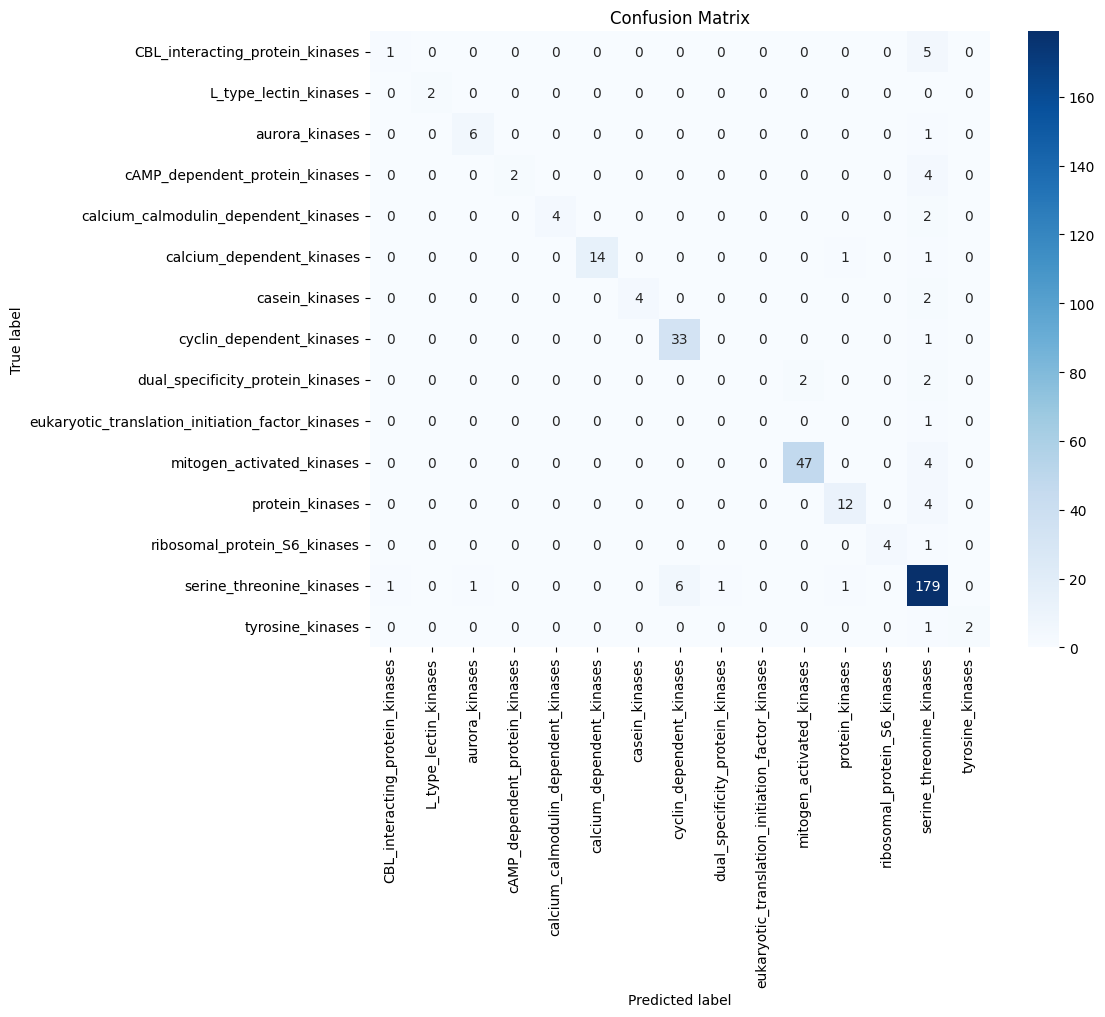

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1) Compute the confusion matrix counts
cm = confusion_matrix(y_val, y_pred)

# 2) Wrap in a DataFrame for nicer indexing
df_cm = pd.DataFrame(cm,
                     index=unique_labels,
                     columns=unique_labels)

# 3) Print the raw matrix
print("Confusion matrix (counts):")
print(df_cm)

# 4) (Optional) Visualize with a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


#### test split

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# a) get predictions
y_pred_probs = clf.predict(Z_test)
y_pred       = np.argmax(y_pred_probs, axis=1)

# b) overall accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.2%}")

# c) confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# d) per‑class metrics
print("\nClassification report:\n",
      classification_report(y_test, y_pred, digits=4))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Test accuracy: 89.77%
Confusion matrix:
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0   5   0]
 [  0   2   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   6   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   3   0   0   0   0   0   0   0   0   0   2   0]
 [  0   0   0   0   6   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0  13   0   0   0   0   0   0   0   3   0]
 [  0   0   0   0   0   0   6   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  34   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   2   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   2   0]
 [  0   0   0   0   0   0   0   0   0   0  49   0   0   2   0]
 [  0   0   0   0   0   0   0   0   0   0   0   9   0   7   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   2   3   0]
 [  1   0   1   0   0   0   0   2   0   0   2   1   0 182   0]
 [  0   0   0   0   0   0   0   0   0

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Test accuracy: 89.77%

Classification report:
               precision    recall  f1-score   support

           0     0.5000    0.1667    0.2500         6
           1     1.0000    1.0000    1.0000         2
           2     0.8571    1.0000    0.9231         6
           3     1.0000    0.6000    0.7500         5
           4     1.0000    0.8571    0.9231         7
           5     1.0000    0.8125    0.8966        16
           6     1.0000    1.0000    1.0000         6
           7     0.9444    0.9714    0.9577        35
           8     0.0000    0.0000    0.0000         3
           9     0.0000    0.0000    0.0000         2
          10     0.9245    0.9608    0.9423        51
          11     0.9000    0.5625    0.6923        16
          12     1.0000    0.4000    0.5714         5
          13     0.8708    0.9630    0.9146       189
          14     1.0000    1.0000    1.0000         3

    accuracy                         0.8977     

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


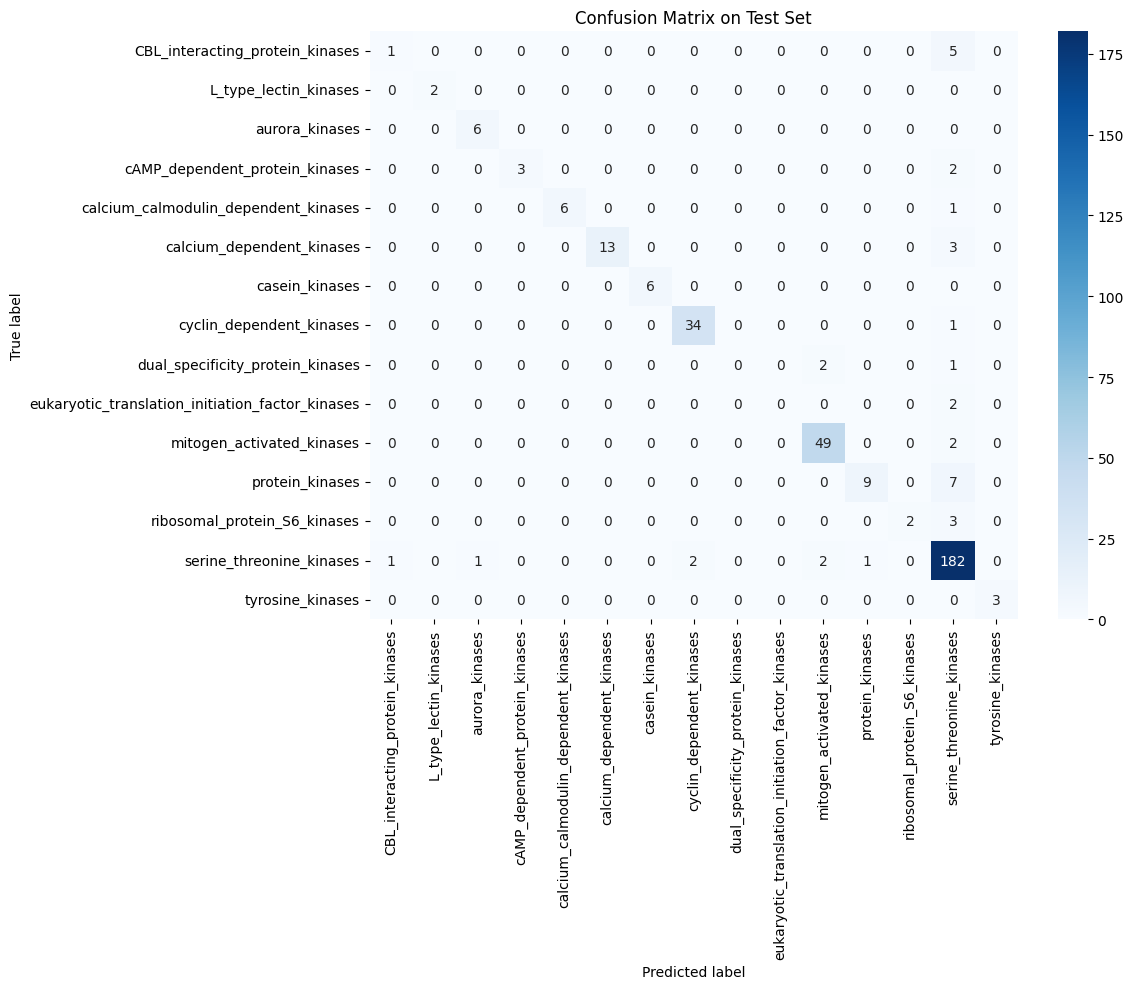

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

# 1) Get predicted labels
y_pred_probs = clf.predict(Z_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2) Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3) Print overall accuracy and detailed report
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.2%}\n")
print("Classification report:\n",
      classification_report(y_test, y_pred, digits=4))

# 4) Visualize with a heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix on Test Set')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### save the model & how to load

In [34]:
# this writes a directory “encoder_3d_to_32” in TensorFlow’s SavedModel format
encoder.save('vae_mlp_2 models/encoder_3d_to_32.keras')
clf.save('vae_mlp_2 models/latent_mlp_classifier.keras')
vae.save('vae_mlp_2 models/protein_vae_model.keras')

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
# from your_module import Sampling, Encoder, Decoder, VAE  # if you need them

# 1) Re-load encoder
encoder = load_model(
    'vae_mlp_2 models/encoder_3d_to_32.keras',
    custom_objects={'Sampling': Sampling,
                    'Encoder': Encoder}
)

# 2) Re-load classifier
clf = load_model('vae_mlp_2 models/latent_mlp_classifier.keras')

"""
# 3) (Optional) Re-load full VAE
vae = load_model(
    'vae_mlp_2 models/protein_vae_model.keras',
    custom_objects={'Sampling': Sampling, 'Encoder': Encoder, 'Decoder': Decoder, 'VAE': VAE}
)
"""



c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


"\n# 3) (Optional) Re-load full VAE\nvae = load_model(\n    'vae_mlp_2 models/protein_vae_model.keras',\n    custom_objects={'Sampling': Sampling, 'Encoder': Encoder, 'Decoder': Decoder, 'VAE': VAE}\n)\n"

### pseudo labeling to augment labled data
we already have 200k one hot encoded unlabled sequences in X_unlab_onehot.npz file

In [39]:
data = np.load('X_unlab_onehot.npz')
print("Keys in archive:", data.files)
X_unlab_onehot = data['arr_0']
print("X_unlab_onehot shape:", X_unlab_onehot.shape)
# X_unlab_onehot : np.ndarray of shape (N_unlab, 263, 21)

# 2) Embed via your encoder to 32‑D
Z_unlab = encoder.predict(X_unlab_onehot, batch_size=256, verbose=1)  # → (N_unlab, 32)

# 3) Get predicted probabilities from your MLP
probs     = clf.predict(Z_unlab, batch_size=256, verbose=1)          # shape (N_unlab, num_classes)
preds     = np.argmax(probs, axis=1)                                  # hard predicted labels
confidences = np.max(probs, axis=1)                                   # confidence scores

# 4) Apply a confidence threshold
threshold = 0.95
mask_confident = confidences >= threshold

# 5) Build your pseudo‑labels array with “-1” for uncertain
y_pseudo = np.where(mask_confident, preds, -1)  # -1 means “uncertain”

# 6) Report coverage and per‑class counts
coverage = mask_confident.mean() * 100
print(f"Labeled {coverage:.1f}% of unlabeled data at ≥{threshold:.0%} confidence")

# Count how many per class (only among the labeled ones)
labeled_counts = pd.Series(preds[mask_confident]).value_counts().sort_index()
uncertain_count = (~mask_confident).sum()
df_counts = pd.DataFrame({
    'class_index': labeled_counts.index,
    'count_labeled': labeled_counts.values
})
df_counts.loc[len(df_counts)] = ['uncertain', uncertain_count]
print(df_counts)

# 7) Save your pseudo‑labels and (optionally) embeddings
np.savez_compressed(
    'vae_mlp_2 models/unlabeled_pseudo_labels.npz',
    Z_unlab=Z_unlab,
    y_pseudo=y_pseudo,
    confidences=confidences
)


Keys in archive: ['arr_0']
X_unlab_onehot shape: (199232, 263, 21)
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step
779/779 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Labeled 14.8% of unlabeled data at ≥95% confidence
  class_index  count_labeled
0           2             42
1           3              7
2           4              6
3           5            219
4           6            123
5           7           1227
6          10           1106
7          11             30
8          13          26824
9   uncertain         169648


created 26k peseudo labels
there is classs imbalance
no seq from class 1 8 9 12 14 15
dominated by class 13 (guess its serin)
show that classifier is confident about class 13 (with trsh 95%)

so i will now go through the whole 800k seq, and make sure to gather seq for all classes


my goal is to find min=200 seq for each class 

###### get all the data 

In [4]:
seq_list = read_fasta('PF00069_noinserts_gaps_noduplicates.fasta')

In [6]:
# this code is here cuz i went untill batch6 laptop crashed, i saved data, now reload, and contintue from batch 7
import os
import numpy as np
from collections import defaultdict

# 1) Directory where you saved class_*.npz
load_dir = 'vae_mlp_2 models/pseudo_per_class'

# 2) Rebuild the buckets
pseudo_buckets  = defaultdict(list)
uncertain_bucket = []

for fname in os.listdir(load_dir):
    if not fname.endswith('.npz'):
        continue
    path = os.path.join(load_dir, fname)
    
    # load the array under key 'X'
    data = np.load(path)
    X = data['X']   # shape (N_cls, 263, 21)
    
    # detect uncertain vs numeric classes by filename
    if fname.startswith('class_uncertain'):
        # put into the uncertain bucket
        if X.size:
            uncertain_bucket.append(X)
        print(f"Loaded uncertain: {X.shape[0]} seqs")
    else:
        # parse the class index from 'class_{cls}.npz'
        cls = int(fname.split('_')[1].split('.')[0])
        if X.size:
            # store as a single chunk in the list
            pseudo_buckets[cls].append(X)
        print(f"Loaded class {cls}: {X.shape[0]} seqs")

# 3) Inspect totals
print("\nTotals after loading:")
for cls in sorted(pseudo_buckets):
    count = sum(arr.shape[0] for arr in pseudo_buckets[cls])
    print(f"  Class {cls:2d}: {count} sequences")
unc_count = sum(arr.shape[0] for arr in uncertain_bucket)
print(f"  Uncertain : {unc_count} sequences")


Loaded class 0: 0 seqs
Loaded class 1: 0 seqs
Loaded class 10: 3694 seqs
Loaded class 11: 80 seqs
Loaded class 12: 0 seqs
Loaded class 13: 1000 seqs
Loaded class 14: 0 seqs
Loaded class 2: 132 seqs
Loaded class 3: 15 seqs
Loaded class 4: 25 seqs
Loaded class 5: 702 seqs
Loaded class 6: 389 seqs
Loaded class 7: 3724 seqs
Loaded class 8: 0 seqs
Loaded class 9: 0 seqs
Loaded uncertain: 0 seqs

Totals after loading:
  Class  2: 132 sequences
  Class  3: 15 sequences
  Class  4: 25 sequences
  Class  5: 702 sequences
  Class  6: 389 sequences
  Class  7: 3724 sequences
  Class 10: 3694 sequences
  Class 11: 80 sequences
  Class 13: 1000 sequences
  Uncertain : 0 sequences


In [7]:
batch1 = seq_list[:100000]

In [14]:
batch2 = seq_list[100000:200000]

In [20]:
batch3 = seq_list[200000:300000]

In [25]:
batch4 = seq_list[300000:400000]

In [30]:
batch5 = seq_list[400000:500000]

In [35]:
batch6 = seq_list[500000:600000]

In [7]:
batch7 = seq_list[600000:700000]

In [14]:
batch8 = seq_list[700000:800000]

In [19]:
batch9 = seq_list[800000:]

In [8]:
X_unlab_onehot_1 = encode_sequences_one_hot_with_gap(batch1, max_length=None)

In [15]:
X_unlab_onehot_2 = encode_sequences_one_hot_with_gap(batch2, max_length=None)

In [21]:
X_unlab_onehot_3 = encode_sequences_one_hot_with_gap(batch3, max_length=None)

In [26]:
X_unlab_onehot_4 = encode_sequences_one_hot_with_gap(batch4, max_length=None)

In [31]:
X_unlab_onehot_5 = encode_sequences_one_hot_with_gap(batch5, max_length=None)

In [36]:
X_unlab_onehot_6 = encode_sequences_one_hot_with_gap(batch6, max_length=None)

In [8]:
X_unlab_onehot_7 = encode_sequences_one_hot_with_gap(batch7, max_length=None)

In [15]:
X_unlab_onehot_8 = encode_sequences_one_hot_with_gap(batch8, max_length=None)

In [20]:
X_unlab_onehot_9 = encode_sequences_one_hot_with_gap(batch9, max_length=None)

In [9]:

X_unlab_onehot_1.shape

(99697, 263, 21)

In [16]:
X_unlab_onehot_2.shape

(99626, 263, 21)

In [22]:
X_unlab_onehot_3.shape

(99644, 263, 21)

In [27]:
X_unlab_onehot_4.shape

(99616, 263, 21)

In [32]:
X_unlab_onehot_5.shape

(99593, 263, 21)

In [37]:
X_unlab_onehot_6.shape

(99555, 263, 21)

In [9]:
X_unlab_onehot_7.shape

(99566, 263, 21)

In [16]:
X_unlab_onehot_8.shape

(99550, 263, 21)

In [21]:
X_unlab_onehot_9.shape

(78500, 263, 21)

In [10]:
num_classes = clf.output_shape[-1]

In [13]:
# creating a dict for saving
from collections import defaultdict

# --- BEGIN GLOBALS: run once before your first chunk ---
# Number of classes in your classifier
num_classes = clf.output_shape[-1]

# This dict will hold lists of one-hot arrays for each class
# e.g. pseudo_buckets[5] = [ array(chunk1_class5), array(chunk2_class5), ... ]
pseudo_buckets = defaultdict(list)

# (Optionally) one bucket for “uncertain” if you care
uncertain_bucket = []

# --- END GLOBALS ---

In [11]:
# Now, for each new chunk of X_unlab_onehot you process, run this:

def pseudo_label_and_bucket(X_unlab_onehot, encoder, clf,
                            threshold=0.95):
    """
    Pseudo-label one-hot batch, then append high-confidence examples
    into the global pseudo_buckets dict.
    """
    # 1) Embed to latent
    Z = encoder.predict(X_unlab_onehot, batch_size=256, verbose=1)
    # 2) Predict
    probs      = clf.predict(Z, batch_size=256, verbose=1)
    preds      = np.argmax(probs, axis=1)
    confidences = probs.max(axis=1)
    # 3) Mask high-confidence
    mask_conf  = confidences >= threshold

    # 4) Report coverage
    coverage = mask_conf.mean() * 100
    print(f"Labeled {coverage:.1f}% of this chunk at ≥{threshold:.0%} confidence")

    # 5) Bucket per class
    for cls in range(num_classes):
        idxs = np.where((preds == cls) & mask_conf)[0]
        if idxs.size:
            # append the sub-array of one-hots for this class
            pseudo_buckets[cls].append(X_unlab_onehot[idxs])
    # 6) (Optional) store uncertain for later
    uncertain_idxs = np.where(~mask_conf)[0]
    if uncertain_idxs.size:
        uncertain_bucket.append(X_unlab_onehot[uncertain_idxs])

    # 7) Print per-class counts this chunk
    counts = {cls: sum(arr.shape[0] for arr in pseudo_buckets[cls])
              for cls in range(num_classes)}
    print("Accumulated counts so far:", counts)

In [12]:
# Example usage (run for your first 200K chunk):
pseudo_label_and_bucket(X_unlab_onehot_1, encoder, clf, threshold=0.95)

# --- Repeat pseudo_label_and_bucket(...) for each of your 4 chunks ---

390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Labeled 16.6% of this chunk at ≥95% confidence
Accumulated counts so far: {0: 0, 1: 0, 2: 31, 3: 3, 4: 7, 5: 129, 6: 64, 7: 637, 8: 0, 9: 0, 10: 747, 11: 22, 12: 0, 13: 14865, 14: 0}


In [17]:
pseudo_label_and_bucket(X_unlab_onehot_2, encoder, clf, threshold=0.95)

390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Labeled 15.6% of this chunk at ≥95% confidence
Accumulated counts so far: {0: 0, 1: 0, 2: 52, 3: 6, 4: 14, 5: 246, 6: 140, 7: 1287, 8: 0, 9: 0, 10: 1433, 11: 42, 12: 0, 13: 28790, 14: 0}


In [23]:
pseudo_label_and_bucket(X_unlab_onehot_3, encoder, clf, threshold=0.95)

390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Labeled 15.1% of this chunk at ≥95% confidence
Accumulated counts so far: {0: 0, 1: 0, 2: 74, 3: 9, 4: 18, 5: 350, 6: 215, 7: 1943, 8: 0, 9: 0, 10: 2030, 11: 57, 12: 0, 13: 42362, 14: 0}


In [28]:
pseudo_label_and_bucket(X_unlab_onehot_4, encoder, clf, threshold=0.95)

390/390 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Labeled 14.9% of this chunk at ≥95% confidence
Accumulated counts so far: {0: 0, 1: 0, 2: 95, 3: 11, 4: 22, 5: 474, 6: 282, 7: 2552, 8: 0, 9: 0, 10: 2602, 11: 65, 12: 0, 13: 55825, 14: 0}


In [33]:
pseudo_label_and_bucket(X_unlab_onehot_5, encoder, clf, threshold=0.95)

390/390 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Labeled 14.7% of this chunk at ≥95% confidence
Accumulated counts so far: {0: 0, 1: 0, 2: 114, 3: 14, 4: 25, 5: 598, 6: 327, 7: 3128, 8: 0, 9: 0, 10: 3161, 11: 69, 12: 0, 13: 69170, 14: 0}


In [38]:
pseudo_label_and_bucket(X_unlab_onehot_6, encoder, clf, threshold=0.95)

389/389 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Labeled 14.4% of this chunk at ≥95% confidence
Accumulated counts so far: {0: 0, 1: 0, 2: 132, 3: 15, 4: 25, 5: 702, 6: 389, 7: 3724, 8: 0, 9: 0, 10: 3694, 11: 80, 12: 0, 13: 82149, 14: 0}


In [12]:
pseudo_label_and_bucket(X_unlab_onehot_7, encoder, clf, threshold=0.95)

389/389 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Labeled 14.3% of this chunk at ≥95% confidence
Accumulated counts so far: {0: 0, 1: 0, 2: 161, 3: 17, 4: 29, 5: 809, 6: 445, 7: 4255, 8: 0, 9: 0, 10: 4148, 11: 87, 12: 0, 13: 14068, 14: 0}


In [17]:
pseudo_label_and_bucket(X_unlab_onehot_8, encoder, clf, threshold=0.95)

389/389 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Labeled 14.2% of this chunk at ≥95% confidence
Accumulated counts so far: {0: 0, 1: 0, 2: 178, 3: 18, 4: 31, 5: 922, 6: 495, 7: 4835, 8: 0, 9: 0, 10: 4643, 11: 101, 12: 0, 13: 26940, 14: 0}


In [22]:
pseudo_label_and_bucket(X_unlab_onehot_9, encoder, clf, threshold=0.95)

307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Labeled 14.2% of this chunk at ≥95% confidence
Accumulated counts so far: {0: 0, 1: 0, 2: 196, 3: 18, 4: 34, 5: 1013, 6: 535, 7: 5259, 8: 0, 9: 0, 10: 5046, 11: 107, 12: 0, 13: 37086, 14: 0}


how many of which class do we have so far:

In [13]:
# Assuming pseudo_buckets is your dict: class_index → list of np.ndarrays

for cls in sorted(pseudo_buckets.keys()):
    # Sum the sizes of all arrays in the list for this class
    total = sum(arr.shape[0] for arr in pseudo_buckets[cls])
    print(f"Class {cls:2d}: {total} sequences")

# (Optional) If you also kept uncertain examples in uncertain_bucket:
uncertain_total = sum(arr.shape[0] for arr in uncertain_bucket)
print(f"Uncertain: {uncertain_total} sequences")


Class  0: 0 sequences
Class  1: 0 sequences
Class  2: 31 sequences
Class  3: 3 sequences
Class  4: 7 sequences
Class  5: 129 sequences
Class  6: 64 sequences
Class  7: 637 sequences
Class  8: 0 sequences
Class  9: 0 sequences
Class 10: 747 sequences
Class 11: 22 sequences
Class 12: 0 sequences
Class 13: 14865 sequences
Class 14: 0 sequences
Uncertain: 83192 sequences


In [18]:
# Assuming pseudo_buckets is your dict: class_index → list of np.ndarrays

for cls in sorted(pseudo_buckets.keys()):
    # Sum the sizes of all arrays in the list for this class
    total = sum(arr.shape[0] for arr in pseudo_buckets[cls])
    print(f"Class {cls:2d}: {total} sequences")

# (Optional) If you also kept uncertain examples in uncertain_bucket:
uncertain_total = sum(arr.shape[0] for arr in uncertain_bucket)
print(f"Uncertain: {uncertain_total} sequences")

Class  0: 0 sequences
Class  1: 0 sequences
Class  2: 52 sequences
Class  3: 6 sequences
Class  4: 14 sequences
Class  5: 246 sequences
Class  6: 140 sequences
Class  7: 1287 sequences
Class  8: 0 sequences
Class  9: 0 sequences
Class 10: 1433 sequences
Class 11: 42 sequences
Class 12: 0 sequences
Class 13: 28790 sequences
Class 14: 0 sequences
Uncertain: 167313 sequences


In [24]:
# Assuming pseudo_buckets is your dict: class_index → list of np.ndarrays

for cls in sorted(pseudo_buckets.keys()):
    # Sum the sizes of all arrays in the list for this class
    total = sum(arr.shape[0] for arr in pseudo_buckets[cls])
    print(f"Class {cls:2d}: {total} sequences")

# (Optional) If you also kept uncertain examples in uncertain_bucket:
uncertain_total = sum(arr.shape[0] for arr in uncertain_bucket)
print(f"Uncertain: {uncertain_total} sequences")

Class  0: 0 sequences
Class  1: 0 sequences
Class  2: 74 sequences
Class  3: 9 sequences
Class  4: 18 sequences
Class  5: 350 sequences
Class  6: 215 sequences
Class  7: 1943 sequences
Class  8: 0 sequences
Class  9: 0 sequences
Class 10: 2030 sequences
Class 11: 57 sequences
Class 12: 0 sequences
Class 13: 42362 sequences
Class 14: 0 sequences
Uncertain: 251909 sequences


In [29]:
# Assuming pseudo_buckets is your dict: class_index → list of np.ndarrays

for cls in sorted(pseudo_buckets.keys()):
    # Sum the sizes of all arrays in the list for this class
    total = sum(arr.shape[0] for arr in pseudo_buckets[cls])
    print(f"Class {cls:2d}: {total} sequences")

# (Optional) If you also kept uncertain examples in uncertain_bucket:
uncertain_total = sum(arr.shape[0] for arr in uncertain_bucket)
print(f"Uncertain: {uncertain_total} sequences")

Class  0: 0 sequences
Class  1: 0 sequences
Class  2: 95 sequences
Class  3: 11 sequences
Class  4: 22 sequences
Class  5: 474 sequences
Class  6: 282 sequences
Class  7: 2552 sequences
Class  8: 0 sequences
Class  9: 0 sequences
Class 10: 2602 sequences
Class 11: 65 sequences
Class 12: 0 sequences
Class 13: 55825 sequences
Class 14: 0 sequences
Uncertain: 336655 sequences


In [34]:
# Assuming pseudo_buckets is your dict: class_index → list of np.ndarrays

for cls in sorted(pseudo_buckets.keys()):
    # Sum the sizes of all arrays in the list for this class
    total = sum(arr.shape[0] for arr in pseudo_buckets[cls])
    print(f"Class {cls:2d}: {total} sequences")

# (Optional) If you also kept uncertain examples in uncertain_bucket:
uncertain_total = sum(arr.shape[0] for arr in uncertain_bucket)
print(f"Uncertain: {uncertain_total} sequences")

Class  0: 0 sequences
Class  1: 0 sequences
Class  2: 114 sequences
Class  3: 14 sequences
Class  4: 25 sequences
Class  5: 598 sequences
Class  6: 327 sequences
Class  7: 3128 sequences
Class  8: 0 sequences
Class  9: 0 sequences
Class 10: 3161 sequences
Class 11: 69 sequences
Class 12: 0 sequences
Class 13: 69170 sequences
Class 14: 0 sequences
Uncertain: 421570 sequences


In [41]:
# Assuming pseudo_buckets is your dict: class_index → list of np.ndarrays

for cls in sorted(pseudo_buckets.keys()):
    # Sum the sizes of all arrays in the list for this class
    total = sum(arr.shape[0] for arr in pseudo_buckets[cls])
    print(f"Class {cls:2d}: {total} sequences")

# (Optional) If you also kept uncertain examples in uncertain_bucket:
uncertain_total = sum(arr.shape[0] for arr in uncertain_bucket)
print(f"Uncertain: {uncertain_total} sequences")

Class  0: 0 sequences
Class  1: 0 sequences
Class  2: 132 sequences
Class  3: 15 sequences
Class  4: 25 sequences
Class  5: 702 sequences
Class  6: 389 sequences
Class  7: 3724 sequences
Class  8: 0 sequences
Class  9: 0 sequences
Class 10: 3694 sequences
Class 11: 80 sequences
Class 12: 0 sequences
Class 13: 82149 sequences
Class 14: 0 sequences
Uncertain: 506821 sequences


In [39]:
# Assuming pseudo_buckets is your dict: class_index → list of np.ndarrays

for cls in sorted(pseudo_buckets.keys()):
    # Sum the sizes of all arrays in the list for this class
    total = sum(arr.shape[0] for arr in pseudo_buckets[cls])
    print(f"Class {cls:2d}: {total} sequences")

# (Optional) If you also kept uncertain examples in uncertain_bucket:
uncertain_total = sum(arr.shape[0] for arr in uncertain_bucket)
print(f"Uncertain: {uncertain_total} sequences")

Class  0: 0 sequences
Class  1: 0 sequences
Class  2: 132 sequences
Class  3: 15 sequences
Class  4: 25 sequences
Class  5: 702 sequences
Class  6: 389 sequences
Class  7: 3724 sequences
Class  8: 0 sequences
Class  9: 0 sequences
Class 10: 3694 sequences
Class 11: 80 sequences
Class 12: 0 sequences
Class 13: 82149 sequences
Class 14: 0 sequences
Uncertain: 506821 sequences


In [13]:
# Assuming pseudo_buckets is your dict: class_index → list of np.ndarrays

for cls in sorted(pseudo_buckets.keys()):
    # Sum the sizes of all arrays in the list for this class
    total = sum(arr.shape[0] for arr in pseudo_buckets[cls])
    print(f"Class {cls:2d}: {total} sequences")

# (Optional) If you also kept uncertain examples in uncertain_bucket:
uncertain_total = sum(arr.shape[0] for arr in uncertain_bucket)
print(f"Uncertain: {uncertain_total} sequences")

Class  0: 0 sequences
Class  1: 0 sequences
Class  2: 161 sequences
Class  3: 17 sequences
Class  4: 29 sequences
Class  5: 809 sequences
Class  6: 445 sequences
Class  7: 4255 sequences
Class  8: 0 sequences
Class  9: 0 sequences
Class 10: 4148 sequences
Class 11: 87 sequences
Class 12: 0 sequences
Class 13: 14068 sequences
Class 14: 0 sequences
Uncertain: 85308 sequences


In [18]:
# Assuming pseudo_buckets is your dict: class_index → list of np.ndarrays

for cls in sorted(pseudo_buckets.keys()):
    # Sum the sizes of all arrays in the list for this class
    total = sum(arr.shape[0] for arr in pseudo_buckets[cls])
    print(f"Class {cls:2d}: {total} sequences")

# (Optional) If you also kept uncertain examples in uncertain_bucket:
uncertain_total = sum(arr.shape[0] for arr in uncertain_bucket)
print(f"Uncertain: {uncertain_total} sequences")

Class  0: 0 sequences
Class  1: 0 sequences
Class  2: 178 sequences
Class  3: 18 sequences
Class  4: 31 sequences
Class  5: 922 sequences
Class  6: 495 sequences
Class  7: 4835 sequences
Class  8: 0 sequences
Class  9: 0 sequences
Class 10: 4643 sequences
Class 11: 101 sequences
Class 12: 0 sequences
Class 13: 26940 sequences
Class 14: 0 sequences
Uncertain: 170714 sequences


In [23]:
# Assuming pseudo_buckets is your dict: class_index → list of np.ndarrays

for cls in sorted(pseudo_buckets.keys()):
    # Sum the sizes of all arrays in the list for this class
    total = sum(arr.shape[0] for arr in pseudo_buckets[cls])
    print(f"Class {cls:2d}: {total} sequences")

# (Optional) If you also kept uncertain examples in uncertain_bucket:
uncertain_total = sum(arr.shape[0] for arr in uncertain_bucket)
print(f"Uncertain: {uncertain_total} sequences")

Class  0: 0 sequences
Class  1: 0 sequences
Class  2: 196 sequences
Class  3: 18 sequences
Class  4: 34 sequences
Class  5: 1013 sequences
Class  6: 535 sequences
Class  7: 5259 sequences
Class  8: 0 sequences
Class  9: 0 sequences
Class 10: 5046 sequences
Class 11: 107 sequences
Class 12: 0 sequences
Class 13: 37086 sequences
Class 14: 0 sequences
Uncertain: 238083 sequences


i need to save what i have labled so far, basically [:600000]
then reload it, and continue, my laptop crashed
from class 13 and uncertain i will only let 1000 and 0 respectively seq to remain

In [ ]:
import numpy as np
import random

# 1) Prune class 13 to 1 000 total examples
cls = 13
if cls in pseudo_buckets and pseudo_buckets[cls]:
    arr_list = pseudo_buckets[cls]
    sizes    = [a.shape[0] for a in arr_list]
    total    = sum(sizes)
    if total > 1000:
        # pick 1 000 global indices
        selected = set(random.sample(range(total), 1000))
        new_list = []
        cum = 0
        for a in arr_list:
            n = a.shape[0]
            # which local indices to keep in this array
            keep = [i for i in range(n) if (cum + i) in selected]
            if keep:
                new_list.append(a[keep])
            cum += n
        pseudo_buckets[cls] = new_list
    print(f"After pruning, class {cls} has {sum(a.shape[0] for a in pseudo_buckets[cls])} examples")

# 2) Clear uncertain bucket entirely
if 'uncertain_bucket' in globals():
    uncertain_bucket = []
    print("Cleared uncertain bucket (now 0 examples)")

# Now you can safely concatenate each class (none will be enormous)
# and save per-class files without MemoryErrors.


After pruning, class 13 has 1000 examples
Cleared uncertain bucket (now 0 examples)


now save them, so that we can reload

In [26]:
import os
import numpy as np

# Directory to hold per-class files
save_dir = 'vae_mlp_2 models/pseudo_per_class_final'
os.makedirs(save_dir, exist_ok=True)

# 1) Save each numeric class
for cls, arr_list in pseudo_buckets.items():
    # Concatenate all arrays (or make empty if none)
    if arr_list:
        X_cls = np.concatenate(arr_list, axis=0)   # (N_cls, 263,21)
    else:
        # no data collected for this class
        X_cls = np.empty((0, 263, 21), dtype=np.float32)

    # Apply rule: for class 13, cap at 1000; for others, keep all
    if cls == 13:
        n_total = X_cls.shape[0]
        if n_total > 1000:
            # randomly sample 1000 without replacement
            idxs = np.random.choice(n_total, size=1000, replace=False)
            X_save = X_cls[idxs]
        else:
            X_save = X_cls
    else:
        X_save = X_cls

    # Save out
    fname = os.path.join(save_dir, f'class_{cls}.npz')
    np.savez_compressed(fname, X=X_save)
    print(f"Saved class {cls:2d} → {X_save.shape[0]:6d} sequences in {fname}")

# 2) Ensure we still write an “uncertain” bucket (empty = 0 seqs)
#    if you have uncertain_bucket list, otherwise it’ll be empty
uncertain_arr = (np.concatenate(uncertain_bucket, axis=0)
                 if 'uncertain_bucket' in globals() and uncertain_bucket
                 else np.empty((0, 263, 21), dtype=np.float32))

fname = os.path.join(save_dir, 'class_uncertain.npz')
np.savez_compressed(fname, X=uncertain_arr)
print(f"Saved uncertain class → {uncertain_arr.shape[0]:6d} sequences in {fname}")


Saved class 10 →   5046 sequences in vae_mlp_2 models/pseudo_per_class_final\class_10.npz
Saved class 11 →    107 sequences in vae_mlp_2 models/pseudo_per_class_final\class_11.npz
Saved class 13 →   1000 sequences in vae_mlp_2 models/pseudo_per_class_final\class_13.npz
Saved class  2 →    196 sequences in vae_mlp_2 models/pseudo_per_class_final\class_2.npz
Saved class  3 →     18 sequences in vae_mlp_2 models/pseudo_per_class_final\class_3.npz
Saved class  4 →     34 sequences in vae_mlp_2 models/pseudo_per_class_final\class_4.npz
Saved class  5 →   1013 sequences in vae_mlp_2 models/pseudo_per_class_final\class_5.npz
Saved class  6 →    535 sequences in vae_mlp_2 models/pseudo_per_class_final\class_6.npz
Saved class  7 →   5259 sequences in vae_mlp_2 models/pseudo_per_class_final\class_7.npz
Saved class  0 →      0 sequences in vae_mlp_2 models/pseudo_per_class_final\class_0.npz
Saved class  1 →      0 sequences in vae_mlp_2 models/pseudo_per_class_final\class_1.npz
Saved class  8 →  

How to load but i will use it upppppp

In [ ]:
"""
import os
import numpy as np
from collections import defaultdict

    # Directory from which to load
load_dir = 'vae_mlp_2 models/pseudo_per_class'

    # Rebuild the buckets dict
pseudo_buckets = defaultdict(list)

for fname in os.listdir(load_dir):
    if not fname.endswith('.npz') or not fname.startswith('class_'):
        continue
    
    cls = int(fname.split('_')[1].split('.')[0])
    data = np.load(os.path.join(load_dir, fname))
    X_cls = data['X']                    # shape (N_cls, 263,21)
    
    # Store as a single-element list so it matches the original structure
    pseudo_buckets[cls].append(X_cls)
    print(f"Loaded class {cls}: {X_cls.shape[0]} sequences")"""

### generating synth sequence to augment labled data


original labled data that we had

Found 15 classes, 1758 total sequences

0    : 31
1    : 12
2    : 32
3    : 27
4    : 32
5    : 80
6    : 31
7    : 172
8    : 17
9    : 8
10   : 255
11   : 78
12   : 23
13   : 944
14   : 16

Label → index mapping:
  CBL_interacting_protein_kinases → 0
  L_type_lectin_kinases          → 1
  aurora_kinases                 → 2
  cAMP_dependent_protein_kinases → 3
  calcium_calmodulin_dependent_kinases → 4
  calcium_dependent_kinases      → 5
  casein_kinases                 → 6
  cyclin_dependent_kinases       → 7
  dual_specificity_protein_kinases → 8
  eukaryotic_translation_initiation_factor_kinases → 9
  mitogen_activated_kinases      → 10
  protein_kinases                → 11
  ribosomal_protein_S6_kinases   → 12
  serine_threonine_kinases       → 13
  tyrosine_kinases               → 14


cls   labled    pseudo          how many synth?     total for training    

0    : 31 →      0              100                 100

1    : 12  →      0             80                  80

2    : 32 →    196              54                  250

3    : 27 →     18              150                 168

4    : 32 →     34              180                 214  
 
5    : 80 →   1013              50                  250+50

6    : 31 →    535              10                  250+10

7    : 172 →   5259             10                   500+10

8    : 17 →      0              80                  80

9    : 8 →      0               30                  30

10   : 254 →   5046             10                   500+10

11   : 78 →    107              150                 250

12   : 23 →      0              100                 100 
   
13   : 944 →   1000             50                   1000+50

14   : 16 →      0              80                  80


the code below create original+pseudo data and save it

In [5]:
# 4) Load full VAE and extract encoder/decoder
"""
vae = load_model(
    'protein_vae.h5',
    custom_objects={'Sampling': Sampling, 'Encoder': Encoder, 'Decoder': Decoder, 'VAE': VAE}
)"""
encoder = vae.encoder
decoder = vae.decoder

In [48]:
import os
import numpy as np
from tensorflow.keras.models import load_model

# --- User parameters ---
dir_m     = 'hmm_20'                                           # directory containing your FASTA
name_m    = 'tyrosine_kinases_noInserts_noGaps_noDuplicates'
dir_n     = 'vae_mlp_2 models/pseudo_per_class_final'          # directory containing your .npz
name_n    = 'class_14'                                          # base name of that .npz
n_pseudo  = 0                                         # how many pseudo to include
N_synth   = 80                                            # how many to generate
dir_p     = 'vae_mlp_2 models/synthetic_per_class'             # where to save synthetic npz
dir_q     = 'vae_mlp_2 models/synthetic_plus_pseudo'           # where to save final merged npz

# --- Helper functions (must be defined elsewhere) ---
# def read_fasta(path) -> List[str]
# def encode_sequences_one_hot_with_gap(seqs, max_length) -> np.ndarray

# 1) Load & one-hot encode the real FASTA
fasta_path = os.path.join(dir_m, name_m + '.fasta')
seqs_real  = read_fasta(fasta_path)
X_real     = encode_sequences_one_hot_with_gap(seqs_real, max_length=263)
print(f"Loaded {X_real.shape[0]} real seqs → X_real shape: {X_real.shape}")

# 2) Load first n_pseudo from pseudo-labeled .npz
npz_path = os.path.join(dir_n, name_n + '.npz')
data     = np.load(npz_path)
X_pseudo = data.get('X', data.get('arr_0'))
X_extra  = X_pseudo[:n_pseudo]
print(f"Selected {X_extra.shape[0]} pseudo-labeled seqs → X_extra shape: {X_extra.shape}")

# 3) Merge real + pseudo one-hots
assert X_real.shape[1:] == X_extra.shape[1:], "Mismatch in (L,alphabet) dims"
X_merged = np.concatenate([X_real, X_extra], axis=0)
print(f"Merged real+pseudo → X_merged shape: {X_merged.shape}")


# 5) Flatten merged for encoder input if needed
M, L, A = X_merged.shape
X_flat   = X_merged.reshape(M, L*A)

# 6) Compute latent means via vae.encode (no predict)
#    returns (z_mean, z_logvar, z_sampled)
z_mean, z_logvar, _ = vae.encode(X_flat)
# z_mean is a Tensor, so convert to NumPy:
z_mean = z_mean.numpy()    # shape (M, latent_dim)

# 7) Generate N_synth synthetic latents
latent_dim = z_mean.shape[1]
seed_idxs  = np.random.choice(M, size=N_synth, replace=True)
base_means = z_mean[seed_idxs]
sigma      = 0.1
z_synth    = base_means + np.random.normal(size=(N_synth, latent_dim)) * sigma

# 8) Decode synthetic latents via vae.decode
X_synth_flat_tf = vae.decode(z_synth)         # EagerTensor shape (N_synth, L*A)
X_synth_flat    = X_synth_flat_tf.numpy()     # now a NumPy array

# 9) Reshape into (N_synth, L, A) and build hard one-hot
probs_flat = X_synth_flat.reshape(N_synth, L, A)
X_synth_oh = np.zeros((N_synth, L, A), dtype=np.int8)
idxs       = np.argmax(probs_flat, axis=-1)   # (N_synth, L)
for i in range(N_synth):
    X_synth_oh[i, np.arange(L), idxs[i]] = 1

print(f"Generated synthetic one-hot → X_synth_oh shape: {X_synth_oh.shape}")

# 9) Save synthetic one-hots as .npz in dir_p
os.makedirs(dir_p, exist_ok=True)
out_synth = os.path.join(dir_p, f'{name_n}_synthetic_{N_synth}.npz')
np.savez_compressed(out_synth, X_synth=X_synth_oh)
print(f"Saved synthetic one-hots to {out_synth}")

Loaded 16 real seqs → X_real shape: (16, 263, 21)
Selected 0 pseudo-labeled seqs → X_extra shape: (0, 263, 21)
Merged real+pseudo → X_merged shape: (16, 263, 21)
Generated synthetic one-hot → X_synth_oh shape: (80, 263, 21)
Saved synthetic one-hots to vae_mlp_2 models/synthetic_per_class\class_14_synthetic_80.npz


Now lets put together pseudo and synth data per class and save them

cls   labled    pseudo          how many synth?     total for training    

0    : 31 →      0              100                 100

1    : 12  →      0             80                  80

2    : 32 →    196              54                  250

3    : 27 →     18              150                 168

4    : 32 →     34              180                 214  
 
5    : 80 →   1013              50                  300+50

6    : 31 →    535              10                  300+10

7    : 172 →   5259             10                   500+10

8    : 17 →      0              80                  80

9    : 8 →      0               30                  30

10   : 254 →   5046             10                   500+10

11   : 78 →    107              150                 250

12   : 23 →      0              100                 100 
   
13   : 944 →   1000             50                   1000+50

14   : 16 →      0              80                  80


In [65]:
import os
import numpy as np

name_n      = 'class_14'            # base name of the pseudo file: class_0.npz
N_pseudo    = 0                 # how many pseudo-labeled seqs to take
name_p       = 'class_14_synthetic_80'  # base name of the synthetic file: class_0_synthetic_5000.npz
# --- User parameters ---
dir_n       = 'vae_mlp_2 models/pseudo_per_class_final'
dir_p       = 'vae_mlp_2 models/synthetic_per_class'
dir_q       = 'vae_mlp_2 models/synthetic_plus_pseudo'
out_name_q  = f'{name_n}.npz'

# 1) Load first N_pseudo from the pseudo-labeled pool
pseudo_path = os.path.join(dir_n, name_n + '.npz')
print(f"Loading pseudo-labeled data from {pseudo_path} …")
pseudo_data = np.load(pseudo_path)
# key might be 'X' or 'arr_0'
X_pseudo_all = pseudo_data.get('X', pseudo_data.get('arr_0'))
print(f" → Found {X_pseudo_all.shape[0]} total pseudo-labeled sequences")

# take only the first N_pseudo (or all if fewer)
X_pseudo = X_pseudo_all[:N_pseudo]
print(f" → Selected first {X_pseudo.shape[0]} pseudo sequences")

# 2) Load all synthetic sequences for that class
synth_path = os.path.join(dir_p, name_p + '.npz')
print(f"\nLoading synthetic data from {synth_path} …")
synth_data = np.load(synth_path)
X_synth    = synth_data.get('X_synth', synth_data.get('X', synth_data.get('arr_0')))
print(f" → Found {X_synth.shape[0]} synthetic sequences")

# 3) Verify shapes match on (L, alphabet)
assert X_pseudo.shape[1:] == X_synth.shape[1:], (
    f"Shape mismatch: pseudo {X_pseudo.shape[1:]} vs synth {X_synth.shape[1:]}"
)
print("\nShapes match. Ready to concatenate.")

# 4) Concatenate
X_combined = np.concatenate([X_pseudo, X_synth], axis=0)
print(f" → Combined dataset shape: {X_combined.shape} "
      f"({X_pseudo.shape[0]} pseudo + {X_synth.shape[0]} synth)")

# 5) Save to output .npz
os.makedirs(dir_q, exist_ok=True)
out_path = os.path.join(dir_q, out_name_q)
print(f"\nSaving combined data to {out_path} …")
np.savez_compressed(out_path, X=X_combined)
print("Done!")

# Final summary
print("\nSummary:")
print(f"  Pseudo-labeled used : {X_pseudo.shape[0]}")
print(f"  Synthetic used      : {X_synth.shape[0]}")
print(f"  Total combined      : {X_combined.shape[0]}")


Loading pseudo-labeled data from vae_mlp_2 models/pseudo_per_class_final\class_14.npz …
 → Found 0 total pseudo-labeled sequences
 → Selected first 0 pseudo sequences

Loading synthetic data from vae_mlp_2 models/synthetic_per_class\class_14_synthetic_80.npz …
 → Found 80 synthetic sequences

Shapes match. Ready to concatenate.
 → Combined dataset shape: (80, 263, 21) (0 pseudo + 80 synth)

Saving combined data to vae_mlp_2 models/synthetic_plus_pseudo\class_14.npz …
Done!

Summary:
  Pseudo-labeled used : 0
  Synthetic used      : 80
  Total combined      : 80


In [ ]:
import os
import numpy as np

# --- User parameters ---
unlabeled_fasta = 'PF00069_noinserts_gaps_noduplicates.fasta'  # FASTA with ~800k sequences
output_dir      = 'vae_mlp_2 models/G'                          # directory to save outputs
n_select        = 1000                                 # number of sequences to pick
n_recon         = 10                                   # reconstructions per sequence
max_length      = 263
amino_acids     = '-ACDEFGHIKLMNPQRSTVWY'

os.makedirs(output_dir, exist_ok=True)

# --- 1) Read all unlabeled sequences ---
seq_list = read_fasta(unlabeled_fasta)
total = len(seq_list)
print(f"Loaded {total} unlabeled sequences from {unlabeled_fasta}")

# --- 2) Randomly select n_select sequences ---
np.random.seed(42)
selected_idxs = np.random.choice(total, size=n_select, replace=False)
selected_seqs = [seq_list[i] for i in selected_idxs]

# Save selected originals (optional)
sel_fasta = os.path.join(output_dir, 'selected_1000.fasta')
with open(sel_fasta, 'w') as f:
    for i, seq in enumerate(selected_seqs):
        f.write(f">orig_{i}\n{seq}\n")
print(f"Saved selected {n_select} sequences to {sel_fasta}")

# --- 3) One-hot encode selected sequences ---
X_sel = encode_sequences_one_hot_with_gap(selected_seqs, max_length=max_length)
# Flatten for VAE: shape (n_select, original_dim)
X_sel_flat = X_sel.reshape(n_select, -1)

# --- 4) Generate reconstructions ---
recon_list = []  # will hold reconstructed one-hots
for run in range(n_recon):
    # VAE reconstruct (includes sampling inside)
    recon_flat = vae(X_sel_flat).numpy()  # shape (n_select, original_dim)
    # Reshape to (n_select, max_length, 21)
    recon_oh = recon_flat.reshape(n_select, max_length, len(amino_acids))
    recon_list.append(recon_oh)
    print(f"  Reconstruction round {run+1}/{n_recon} done")

# Concatenate all reconstructions: (n_select * n_recon, max_length, 21)
X_recon = np.concatenate(recon_list, axis=0)
print(f"Total reconstructed sequences: {X_recon.shape[0]}")

# --- 5) Convert one-hots to sequences and save FASTA ---
out_fasta = os.path.join(output_dir, f'reconstructed_{n_select * n_recon}.fasta')
with open(out_fasta, 'w') as f:
    idx = 0
    for batch in recon_list:
        for row in batch:
            aa_idxs = np.argmax(row, axis=1)
            seq = ''.join(amino_acids[j] for j in aa_idxs)
            f.write(f">recon_{idx}\n{seq}\n")
            idx += 1

print(f"Saved {idx} reconstructed sequences to {out_fasta}")


Loaded 878827 unlabeled sequences from PF00069_noinserts_gaps_noduplicates.fasta
Saved selected 1000 sequences to vae_mlp_2 models/pseudo_per_class_final\selected_1000.fasta


ValueError: cannot reshape array of size 5473293 into shape (1000,newaxis)

#### do the whole training again with cross validation

In [25]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# 1) Precompute embeddings for all data
#    (X_lab_onehot, y_lab should already be defined)
encoder.trainable = False
Z_all = encoder.predict(X_lab_onehot, batch_size=64, verbose=1)  # (N, 32)
y_all = y_lab

# 2) Prepare Stratified K‑Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 3) Utility to build a fresh classifier each fold
def build_classifier(input_dim, num_classes):
    model = Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name='latent_mlp')
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

input_dim   = Z_all.shape[1]
num_classes = len(np.unique(y_all))

# 4) Run cross‐validation
fold_accuracies = []
for fold, (train_idx, test_idx) in enumerate(skf.split(Z_all, y_all), start=1):
    Z_tr, Z_te = Z_all[train_idx], Z_all[test_idx]
    y_tr, y_te = y_all[train_idx], y_all[test_idx]
    
    # Build & train
    clf_cv = build_classifier(input_dim, num_classes)
    clf_cv.fit(
        Z_tr, y_tr,
        validation_data=(Z_te, y_te),
        batch_size=32,
        epochs=50,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=3,
                restore_best_weights=True
            )
        ],
        verbose=0
    )
    
    # Evaluate
    y_pred = np.argmax(clf_cv.predict(Z_te), axis=1)
    acc = accuracy_score(y_te, y_pred)
    fold_accuracies.append(acc)
    
    print(f"Fold {fold} Accuracy: {acc:.2%}")
    print("Classification Report:")
    print(classification_report(y_te, y_pred, digits=4))
    print("-" * 60)

# 5) Summarize
mean_acc = np.mean(fold_accuracies)
std_acc  = np.std(fold_accuracies)
print(f"Cross‑Validation Accuracy: {mean_acc:.2%} ± {std_acc:.2%}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Fold 1 Accuracy: 88.92%
Classification Report:
              precision    recall  f1-score   support

           0     0.3333    0.1667    0.2222         6
           1     1.0000    1.0000    1.0000         3
           2     1.0000    0.7143    0.8333         7
           3     1.0000    0.5000    0.6667         6
           4     1.0000    0.8333    0.9091         6
           5     1.0000    1.0000    1.0000        16
           6     1.0000    1.0000    1.0000         6
           7     0.7857    0.9706    0.8684        34
           8     0.6667    0.5000    0.5714         4
           9     0.0000    0.0000    0.0000         1
          10     0.9778    0.8627    0.9167        51
          11     1.0000    0.8000    0.8889        15
          12     1.0000    0.8000    0.8889         5
          13     0.8713    0.9312    0.9003       189
          14     1.0000    1.0000    1.0000         3

    acc

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Fold 2 Accuracy: 88.07%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         6
           1     1.0000    1.0000    1.0000         3
           2     1.0000    0.8571    0.9231         7
           3     1.0000    0.6000    0.7500         5
           4     1.0000    1.0000    1.0000         6
           5     0.9333    0.8750    0.9032        16
           6     1.0000    0.8571    0.9231         7
           7     0.9429    0.9706    0.9565        34
           8     0.0000    0.0000    0.0000         4
           9     0.0000    0.0000    0.0000         1
          10     0.9184    0.9000    0.9091        50
          11     1.0000    0.5000    0.6667        16
          12     1.0000    0.4000    0.5714         5
          13     0.8426    0.9681    0.9010       188
          14     0.6667    0.5000    0.5714         4

    accuracy                         0.8807   

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 3 Accuracy: 84.62%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         7
           1     0.0000    0.0000    0.0000         2
           2     1.0000    0.6667    0.8000         6
           3     1.0000    0.8000    0.8889         5
           4     1.0000    0.2857    0.4444         7
           5     1.0000    0.8125    0.8966        16
           6     1.0000    0.6667    0.8000         6
           7     0.9688    0.9118    0.9394        34
           8     1.0000    0.3333    0.5000         3
           9     0.0000    0.0000    0.0000         2
          10     0.8723    0.8039    0.8367        51
          11     0.8889    0.5000    0.6400        16
          12     1.0000    0.5000    0.6667         4
          13     0.8000    0.9735    0.8783       189
          14     1.0000    1.0000    1.0000         3

    accuracy                         0.8462    

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 4 Accuracy: 85.47%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         6
           1     1.0000    0.5000    0.6667         2
           2     1.0000    0.6667    0.8000         6
           3     1.0000    0.6000    0.7500         5
           4     1.0000    0.4286    0.6000         7
           5     0.8667    0.8125    0.8387        16
           6     1.0000    0.8333    0.9091         6
           7     0.9143    0.9143    0.9143        35
           8     0.0000    0.0000    0.0000         3
           9     0.0000    0.0000    0.0000         2
          10     0.8936    0.8235    0.8571        51
          11     1.0000    0.5625    0.7200        16
          12     1.0000    0.7500    0.8571         4
          13     0.8178    0.9735    0.8889       189
          14     1.0000    0.3333    0.5000         3

    accuracy                         0.8547    

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 5 Accuracy: 86.89%
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         6
           1     1.0000    0.5000    0.6667         2
           2     0.8000    0.6667    0.7273         6
           3     1.0000    0.6667    0.8000         6
           4     1.0000    0.8333    0.9091         6
           5     1.0000    0.6250    0.7692        16
           6     1.0000    0.8333    0.9091         6
           7     0.8947    0.9714    0.9315        35
           8     1.0000    0.3333    0.5000         3
           9     0.0000    0.0000    0.0000         2
          10     0.9583    0.9020    0.9293        51
          11     0.7778    0.4667    0.5833        15
          12     1.0000    0.8000    0.8889         5
          13     0.8318    0.9683    0.8949       189
          14     1.0000    0.3333    0.5000         3

    accuracy                         0.8689    

c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sajdv\anaconda3\envs\vae\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
